# Data Prep

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import exposure
from PIL import Image
import skimage.measure
import os
import cv2

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("test.csv")

In [3]:
train_df

,filename,diagnostic
0,PAD-UFES-20/PAT_735_1391_683.png,ACK
1,PAD-UFES-20/PAT_1722_3214_672.png,ACK
2,PAD-UFES-20/PAT_730_1385_585.png,BCC
3,PAD-UFES-20/PAT_999_20_223.png,ACK
4,PAD-UFES-20/PAT_625_1184_994.png,SEK
...,...,...
1833,PAD-UFES-20/PAT_718_1358_919.png,BCC
1834,PAD-UFES-20/PAT_2153_4782_321.png,ACK
1835,PAD-UFES-20/PAT_930_1760_560.png,BCC
1836,PAD-UFES-20/PAT_652_1231_516.png,BCC


In [4]:
val_df

,filename,diagnostic
0,PAD-UFES-20/PAT_967_1827_247.png,BCC
1,PAD-UFES-20/PAT_905_1721_327.png,BCC
2,PAD-UFES-20/PAT_1661_2956_357.png,ACK
3,PAD-UFES-20/PAT_1107_427_352.png,NEV
4,PAD-UFES-20/PAT_2077_4463_77.png,ACK
...,...,...
455,PAD-UFES-20/PAT_1922_3848_451.png,SEK
456,PAD-UFES-20/PAT_1468_3656_337.png,ACK
457,PAD-UFES-20/PAT_406_809_581.png,BCC
458,PAD-UFES-20/PAT_1573_2497_736.png,ACK


In [5]:
BATCH_SIZE = 4
IMG_SIZE = 224
NUM_CLASSES = train_df["diagnostic"].nunique()
TRAIN_RATIO = 0.8

In [6]:
datagen = ImageDataGenerator (
    rescale = 1/255.,
)

training_generator = datagen.flow_from_dataframe (
    train_df,
    x_col = "filename",
    y_col = "diagnostic",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
    shuffle=False
)

val_generator = datagen.flow_from_dataframe (
    val_df,
    x_col = "filename",
    y_col = "diagnostic",
    batch_size = BATCH_SIZE,
    target_size = ((IMG_SIZE, IMG_SIZE)),
)

Found 1838 validated image filenames belonging to 6 classes.
Found 460 validated image filenames belonging to 6 classes.


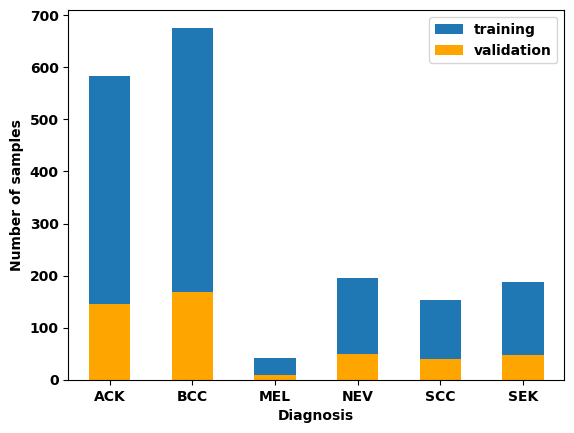

In [7]:
# plt.hist(training_generator.labels)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
train_df.diagnostic.value_counts().sort_index().plot.bar(label="training")
val_df.diagnostic.value_counts().sort_index().plot.bar(label="validation", color="orange")
plt.xlabel("Diagnosis")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.legend()
plt.show()

In [8]:
train_df.diagnostic.value_counts().sort_index()

ACK    584
BCC    676
MEL     42
NEV    195
SCC    153
SEK    188
Name: diagnostic, dtype: int64

(array([146.,   0., 169.,   0.,  10.,   0.,  49.,   0.,  39.,  47.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

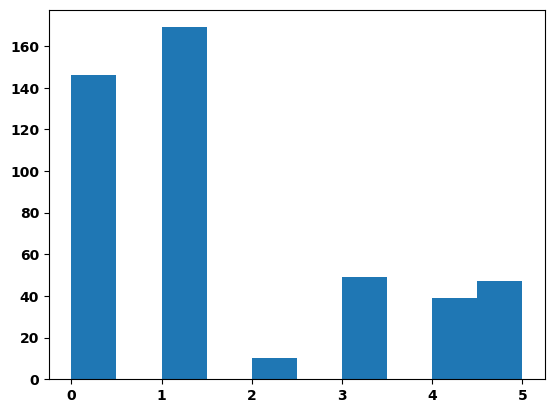

In [9]:
plt.hist(val_generator.labels)

In [10]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(training_generator.classes), 
    y = training_generator.classes)
class_weights = dict(zip(np.unique(training_generator.classes), class_weights))
class_weights

{0: 0.5245433789954338,
 1: 0.4531558185404339,
 2: 7.2936507936507935,
 3: 1.570940170940171,
 4: 2.002178649237473,
 5: 1.6294326241134751}

In [11]:
classes = train_df["diagnostic"].unique()

# Train Teacher branch - MobileNet

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [13]:
def build_Mobilenet_model():
    backbone_model = MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_tensor=tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
    )

    pooling  = tf.keras.layers.GlobalMaxPooling2D()(backbone_model.output)
    
    dense = tf.keras.layers.Dense(units = 1024, kernel_regularizer= tf.keras.regularizers.l2(0.0001))(pooling)
    batch_norm = tf.keras.layers.BatchNormalization()(dense)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm)
    
    classifier = tf.keras.layers.Dense(units = NUM_CLASSES, activation = 'softmax')(leaky_relu)
    model = tf.keras.models.Model(inputs = backbone_model.input, outputs = classifier)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics = ['accuracy'])
    
    # Added to improve gradcam output
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.ZeroPadding2D):
            continue
        layer.padding = "same"
            
    return model

In [14]:
mobilenet_model = build_Mobilenet_model()

In [15]:
mobilenet_model.load_weights("models_self/94_1.567_0.611.h5")

In [ ]:
EPOCHS = 100

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=1e-6)
checkpoint = tf.keras.callbacks.ModelCheckpoint('models_self/{epoch:02d}_{val_loss:.3f}_{val_accuracy:.3f}.h5', monitor='val_accuracy', verbose=1, 
                             mode='max', save_weights_only = True)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]
mycallbacks = [learning_rate_reduction,checkpoint]

In [ ]:
history = mobilenet_model.fit_generator(
    training_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = mycallbacks,
    class_weight=class_weights
)

In [ ]:
# Plot accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_accuracy = mobilenet_model.evaluate(val_generator)
print(val_loss, val_accuracy)

In [ ]:
mobilenet_model.save_weights(f"models_dense_lessfc_gradcam/Global/190_{val_loss:.3f}_{val_accuracy:.3f}.h5")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

y_pred_all = []
y_test_all = []
labels = list(val_generator.class_indices.keys())
print(labels)

STEPS_PER_EPOCH = val_generator.samples//BATCH_SIZE
for i in range(STEPS_PER_EPOCH):
    print(f"\r{i}/{STEPS_PER_EPOCH}", end = "")
    x, y_test = val_generator.next()
    y_pred = mobilenet_model(x, training=False)
    for y in y_test:
        y_test_all.append(tf.argmax(y))
        
    for y in y_pred:
        y_pred_all.append(tf.argmax(y))
        
cm = confusion_matrix(y_test_all, y_pred_all)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

# Metrics

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score, balanced_accuracy_score, classification_report

In [ ]:
def get_metrics(prediction_function):
    y_pred = []
    y_pred_max = []
    y_true = []

    num_steps = val_generator.samples//BATCH_SIZE

    for i in range(num_steps):
        print(f"\r{i}/{num_steps}", end="")
        x, y = val_generator.next()
        y_pred_batch = prediction_function(x, y)
        y_pred_batch/= tf.reshape(
            tf.reduce_sum(y_pred_batch, axis=1), 
            (-1, 1)
        )
        y_pred += list(y_pred_batch.numpy())
        y_pred_max += list(tf.argmax(y_pred_batch, axis=1).numpy())
        y_true += list(tf.argmax(y, axis=1).numpy())
    
    print()
    acc = accuracy_score(y_true, y_pred_max)
    print("Accuracy: ", acc)
    
    precision = precision_score(y_true, y_pred_max, average="weighted")
    print("Precision: ", precision)
    
    recall = recall_score(y_true, y_pred_max, average="weighted")
    print("Recall: ", recall)
    
    f1 = f1_score(y_true, y_pred_max, average="weighted")
    print("F1: ", f1)

    auc = roc_auc_score(y_true, y_pred, average="weighted", multi_class='ovr')
    print("AUC: ", auc)
#     return y_true, y_pred
    return classification_report(y_true, y_pred_max, digits=5)

In [ ]:
def pred_student(images, labels):
    return mobilenet_model(images, training=False)

In [ ]:
class_report_distilled = get_metrics(pred_student)
print(class_report_distilled)

# Saliency

In [16]:
from skimage.transform import resize

In [17]:
@tf.function
def normalize(heatmap):
    num = heatmap - tf.reduce_min(heatmap)
    deno = (tf.reduce_max(heatmap) - tf.reduce_min(heatmap))
    if deno == 0:
        return heatmap
    heatmap = num / deno
    return heatmap

In [18]:
@tf.function
def compute_saliency_map(model, image, eps=1e-8):
    gradModel = tf.keras.models.Model(
        inputs=[model.inputs],
        outputs=model.outputs
    )

    with tf.GradientTape(persistent = True) as tape:
        input_image = tf.cast(image, tf.float32)
        tape.watch(input_image)
        predictions = model(input_image)
        classid = tf.argmax(predictions[0])
        loss = predictions[:, classid]

    gradient = tape.gradient(loss, image)
    gradient = tf.reduce_max(gradient, axis=-1)
    heatmap = gradient.numpy()        

    heatmap = tf.squeeze(heatmap)
    heatmap = normalize(heatmap)
    return heatmap

In [19]:
@tf.function
def generate_saliency_batch(imgs, global_model):
    fused_heatmaps = []
    for image in imgs:
        heatmap = compute_saliency_map(global_model, tf.expand_dims(image, axis=0))
        fused_heatmaps.append(heatmap)

    return tf.convert_to_tensor(fused_heatmaps, tf.float32)

In [20]:
def overlay_heatmap(heatmap, image, alpha=0.5,colormap=cv2.COLORMAP_JET):
    heatmap = cv2.cvtColor(cv2.applyColorMap((heatmap * 255.).astype("uint8"), colormap), cv2.COLOR_BGR2RGB)
    output = cv2.addWeighted((image * 255.).astype("uint8"), alpha, heatmap, 1 - alpha, 0)
    return output

# Visualize and Save attention maps

In [21]:
training_generator.class_indices

{'ACK': 0, 'BCC': 1, 'MEL': 2, 'NEV': 3, 'SCC': 4, 'SEK': 5}

In [22]:
images, labels = training_generator.next()

In [24]:
%%time
heatmaps = generate_saliency_batch(images, mobilenet_model)

CPU times: total: 3.22 s
Wall time: 3.44 s


In [25]:
overlaid_images = [overlay_heatmap(hmap.numpy(), img, alpha=0.8) for (hmap, img) in zip(heatmaps, images)]

In [26]:
print("True labels: ", tf.argmax(labels, axis = 1).numpy())
print("Predictions: ", tf.argmax(mobilenet_model(images), axis=1).numpy())

True labels:  [0 0 1 0]
Predictions:  [4 0 1 0]


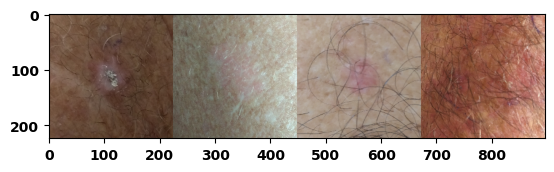

In [27]:
plt.imshow(np.hstack(images))

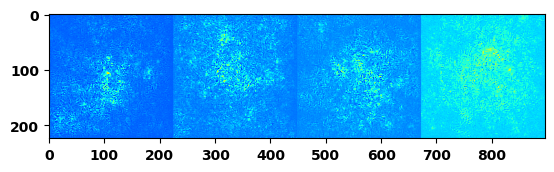

In [28]:
plt.imshow(np.hstack(heatmaps), cmap="jet")

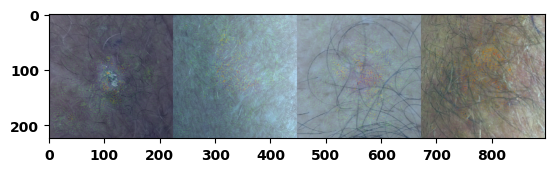

In [29]:
plt.imshow(np.hstack(overlaid_images))

In [ ]:
OUTPUT_FOLDER = "MIPS_teacher"
!mkdir "$OUTPUT_FOLDER"

In [ ]:
IMAGE_START = 8

In [ ]:
!mkdir "$OUTPUT_FOLDER/images"
for img_id, (img, label) in enumerate(zip(images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/images/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/gradcams"
for img_id, (img, label) in enumerate(zip(heatmaps, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/gradcams/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")

In [ ]:
!mkdir "$OUTPUT_FOLDER/overlaid"
for img_id, (img, label) in enumerate(zip(overlaid_images, labels)):
    plt.imsave(f"{OUTPUT_FOLDER}/overlaid/{img_id + IMAGE_START}_{tf.argmax(label)}.jpg", img, cmap="jet")